# Code

In [1]:
import qpm
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
_DATA_DIR = '../Data'

_SAMPLE_START = '2006-01-01'
_SAMPLE_END = '2023-08-31'
_REMOVE_MICRO_CAPS = True
_NUM_PORT = 5

In [3]:
df = qpm.load_data(data_dir = _DATA_DIR, file_name = 'MasterData.parquet')
df['excess_ret'] = df['daret'] - df['rf']

> Loading Raw Data...
> Renaming key variables...
> Dropping duplicates...
> Creating Auxiliary Variables...


In [4]:
mkt = df[['mktrf', 'ldate']].groupby('ldate').first()
mkt['Down'] = np.where(mkt < 0, 1, 0)

In [5]:
def get_signal(excess_ret, mkt, window_size):
    """
    Given the excess returns of an asset and the excess market returns labeled with whether the market is down, return the signals.
    """
    
    asset_id = excess_ret.columns[0]
    df_aligned = excess_ret.join(mkt)
    df_down = df_aligned[df_aligned['Down']==1]
    beta = 0  / df_aligned['mktrf'].rolling(window_size).var() # just to make the code work
    beta_down = df_down[asset_id].rolling(window_size).cov(df_down['mktrf']) / df_down['mktrf'].rolling(window_size).var()
    signal = (beta_down - beta).ffill()
    
    return signal

Window Size = 4

In [6]:
for permno in tqdm(df['permno'].unique()):
    excess_ret = df.loc[df['permno']==permno, ['excess_ret', 'ldate']].set_index('ldate').rename(columns={"excess_ret": permno})
    df.loc[df['permno']==permno, 'signal'] = get_signal(excess_ret, mkt, 4).values

100%|███████████████████████████████████████████████████████████████████████████| 11153/11153 [01:17<00:00, 143.77it/s]


In [7]:
df['signal'] = qpm.create_lag(df, var_name='signal', lag=1)
df_select = qpm.select_sample(df, sample_start = _SAMPLE_START, sample_end = _SAMPLE_END, remove_micro_caps = _REMOVE_MICRO_CAPS)

> Selecting Sample for Given Criteria...


In [8]:
df_select, df_rets = qpm.create_portfolios(df_select, sort_frequency = 'Monthly', num_port = _NUM_PORT)
print(df_rets.tail())

> Sorting stocks into 5 portfolios at frequency: Monthly...
> Computing returns using various weights...
         ldate  retP_rank_longonly  retP_rank_longshort  retP_vw_P1  \
206 2023-03-01           -0.032370            -0.021433    0.006585   
207 2023-04-01           -0.021866            -0.023744    0.024882   
208 2023-05-01           -0.006643             0.022102   -0.034157   
209 2023-06-01            0.087191             0.027025    0.054453   
210 2023-07-01            0.063704             0.028491    0.026998   

     retP_vw_P2  retP_vw_P3  retP_vw_P4  retP_vw_P5   retF_vw  
206    0.029373    0.000794    0.051751    0.051728  0.045143  
207    0.012286    0.002405    0.017970   -0.039121 -0.064002  
208   -0.010706   -0.016612    0.015129    0.113427  0.147584  
209    0.056307    0.065761    0.075622    0.120433  0.065980  
210    0.032144    0.040997    0.026034    0.067998  0.040999  


> Merging strategy returns with Fama and French factor returns...


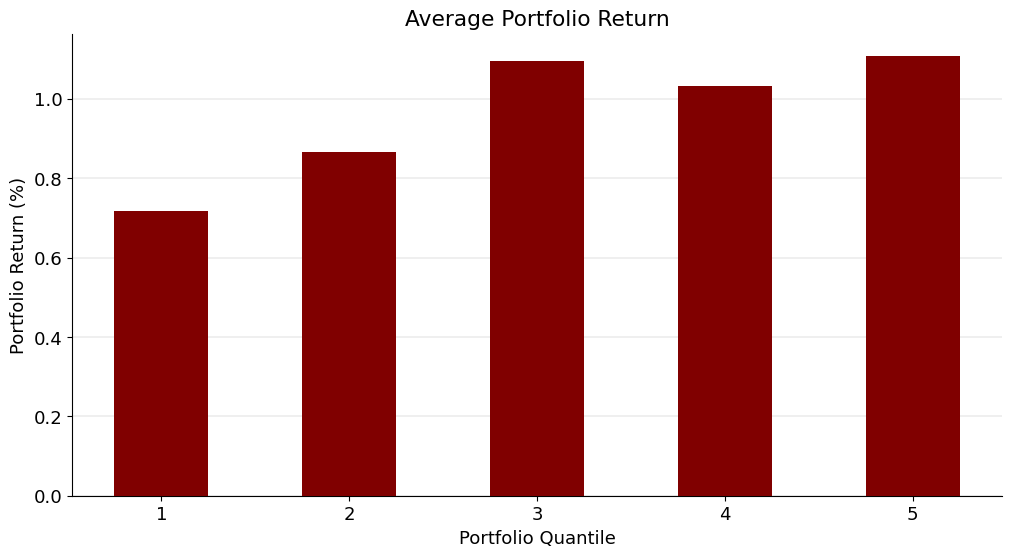

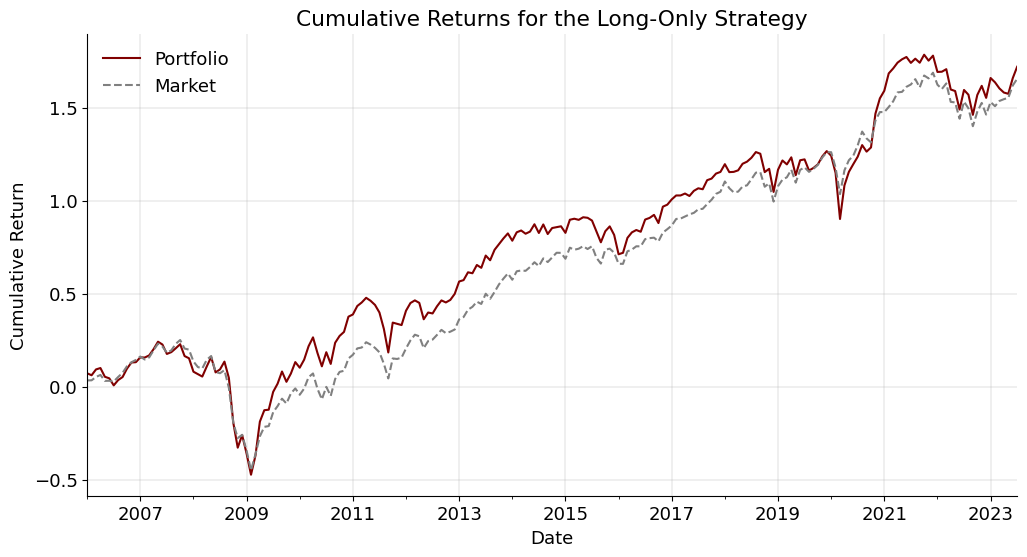

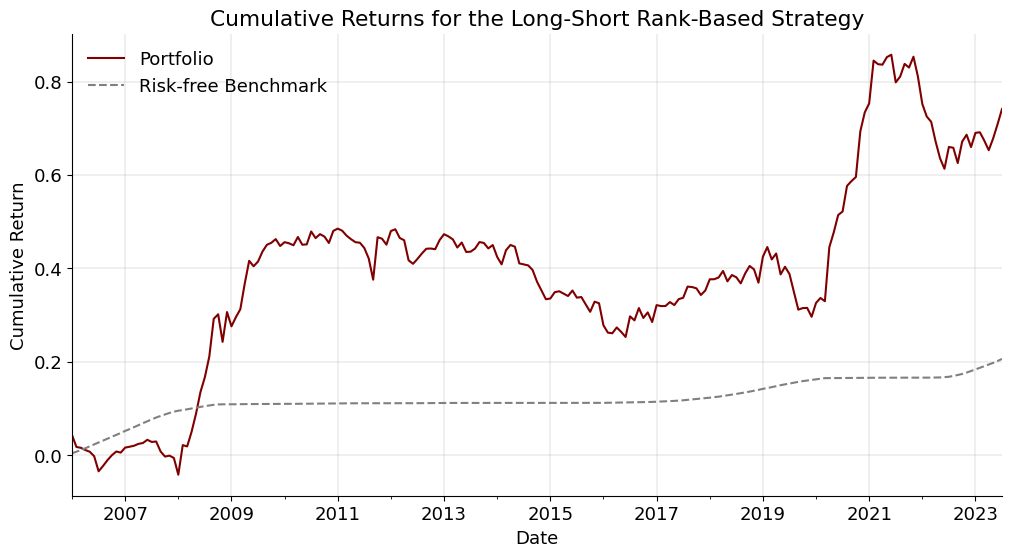

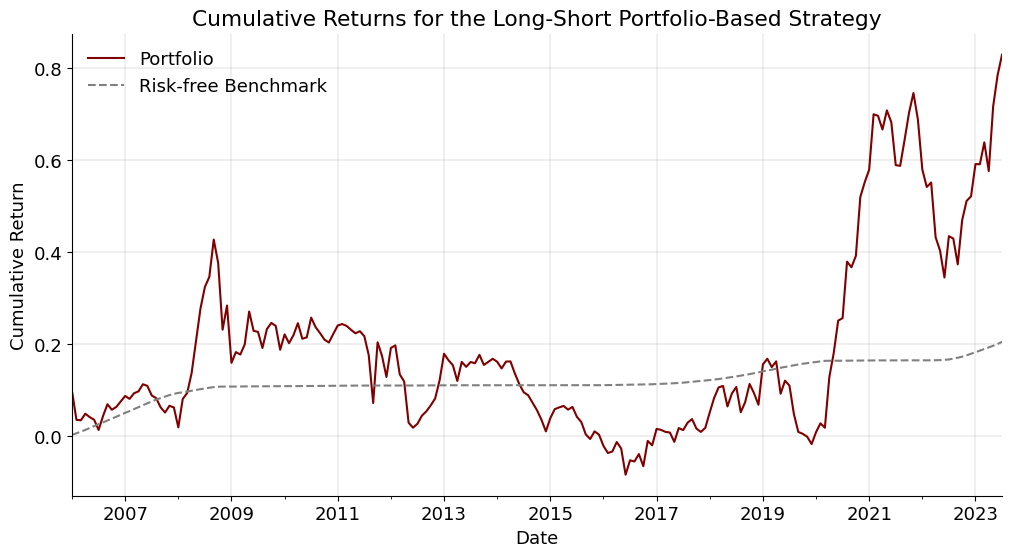

In [9]:
qpm.analyze_strategy(df_rets, analysis_type = 'Performance')

In [10]:
qpm.analyze_strategy(df_rets, analysis_type = 'Summary')

> Merging strategy returns with Fama and French factor returns...
                     count      mean       std       min       25%       50%  \
retP_rank_longonly   211.0  0.010032  0.060665 -0.219463 -0.019084  0.013669   
retP_rank_longshort  211.0  0.002906  0.027320 -0.057646 -0.012235 -0.001123   
retF_vw              211.0  0.003920  0.043926 -0.135284 -0.017393 -0.001483   
mktrf                211.0  0.007964  0.046025 -0.172300 -0.016500  0.012900   
smb                  211.0  0.000377  0.026033 -0.082800 -0.018000  0.001200   
hml                  211.0 -0.001523  0.033234 -0.138700 -0.018600 -0.003400   

                          75%       max  
retP_rank_longonly   0.042693  0.200961  
retP_rank_longshort  0.013217  0.122672  
retF_vw              0.022966  0.147584  
mktrf                0.032850  0.136500  
smb                  0.016100  0.071300  
hml                  0.013350  0.127500  


In [11]:
qpm.analyze_strategy(df_rets, analysis_type = 'Factor Regression')

> Merging strategy returns with Fama and French factor returns...

---------------------------------------------------------------
> Running Factor Regressions: Table 1  - 3 Fama-French Factors
---------------------------------------------------------------

                  (1)       (2)       (3)       (4)       (5)       (6)   
--------------------------------------------------------------------------
const          0.0006    -0.0009   0.0009    0.0009    0.0002    0.0012   
               (0.0028)  (0.0014)  (0.0017)  (0.0027)  (0.0007)  (0.0017) 
mktrf          0.4201*** 1.2504*** 0.2479*** 0.3428*** 1.1006*** 0.1861***
               (0.0593)  (0.0293)  (0.0373)  (0.0623)  (0.0153)  (0.0385) 
hml                                          -0.0675   0.0855*** -0.0520  
                                             (0.0842)  (0.0206)  (0.0520) 
smb                                          0.4064*** 0.6666*** 0.3237***
                                             (0.1142)  (0.0280)  (

Window Size = 12

100%|███████████████████████████████████████████████████████████████████████████| 11153/11153 [01:25<00:00, 130.11it/s]


> Selecting Sample for Given Criteria...
> Sorting stocks into 5 portfolios at frequency: Monthly...
> Computing returns using various weights...
> Merging strategy returns with Fama and French factor returns...


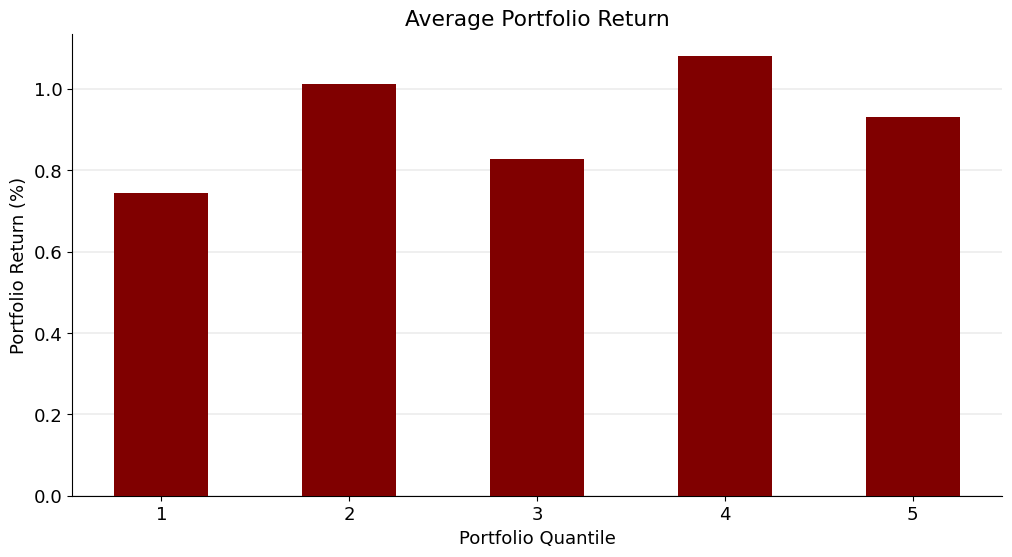

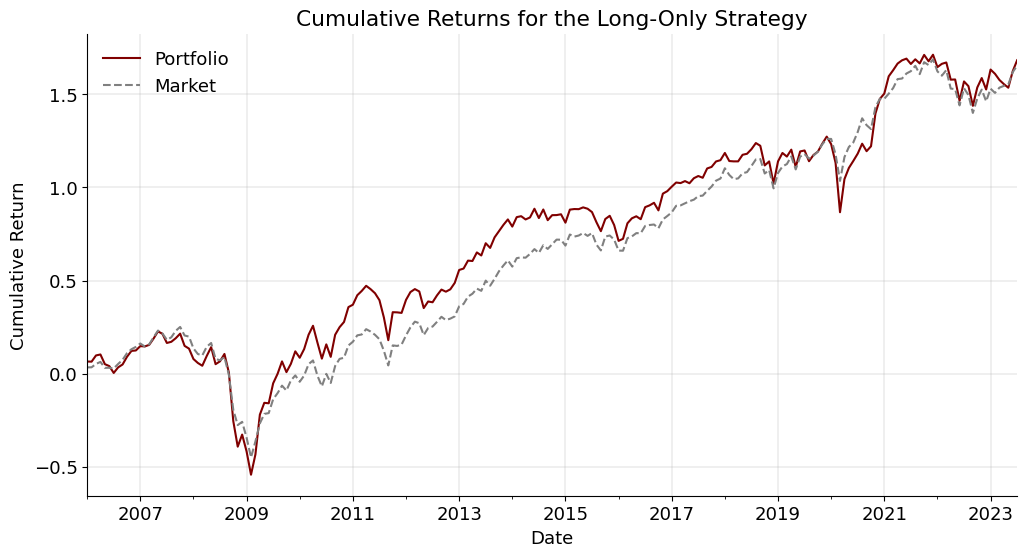

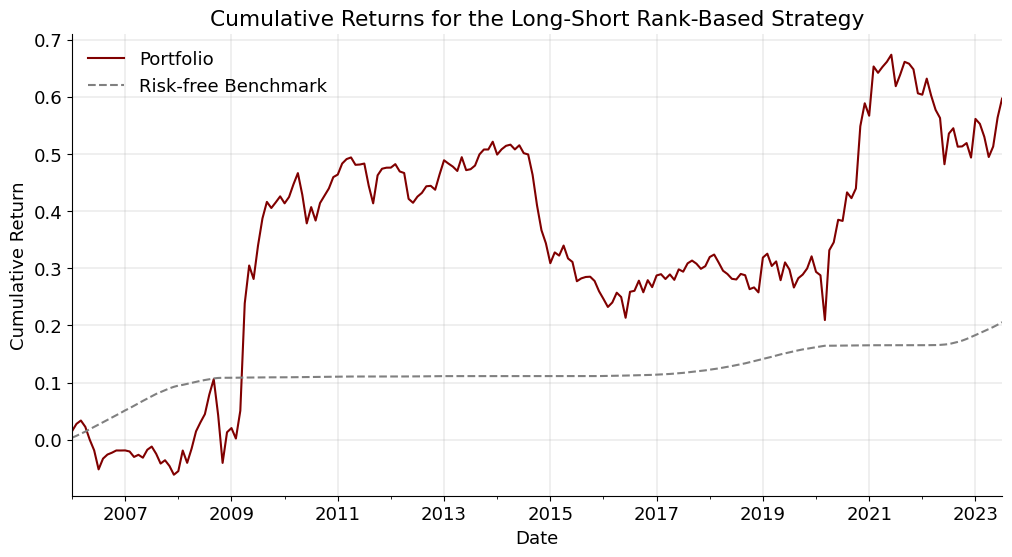

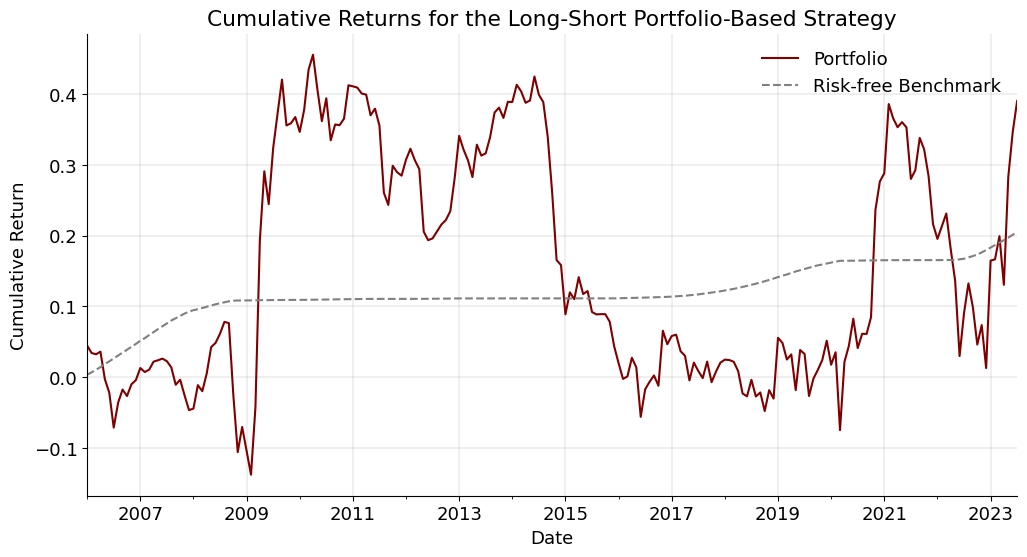

In [12]:
for permno in tqdm(df['permno'].unique()):
    excess_ret = df.loc[df['permno']==permno, ['excess_ret', 'ldate']].set_index('ldate').rename(columns={"excess_ret": permno})
    df.loc[df['permno']==permno, 'signal'] = get_signal(excess_ret, mkt, 12).values
    
df['signal'] = qpm.create_lag(df, var_name='signal', lag=1)
df_select = qpm.select_sample(df, sample_start = _SAMPLE_START, sample_end = _SAMPLE_END, remove_micro_caps = _REMOVE_MICRO_CAPS)

df_select, df_rets = qpm.create_portfolios(df_select, sort_frequency = 'Monthly', num_port = _NUM_PORT)

qpm.analyze_strategy(df_rets, analysis_type = 'Performance')

Window Size = 36

100%|███████████████████████████████████████████████████████████████████████████| 11153/11153 [01:28<00:00, 125.82it/s]


> Selecting Sample for Given Criteria...
> Sorting stocks into 5 portfolios at frequency: Monthly...
> Computing returns using various weights...
> Merging strategy returns with Fama and French factor returns...


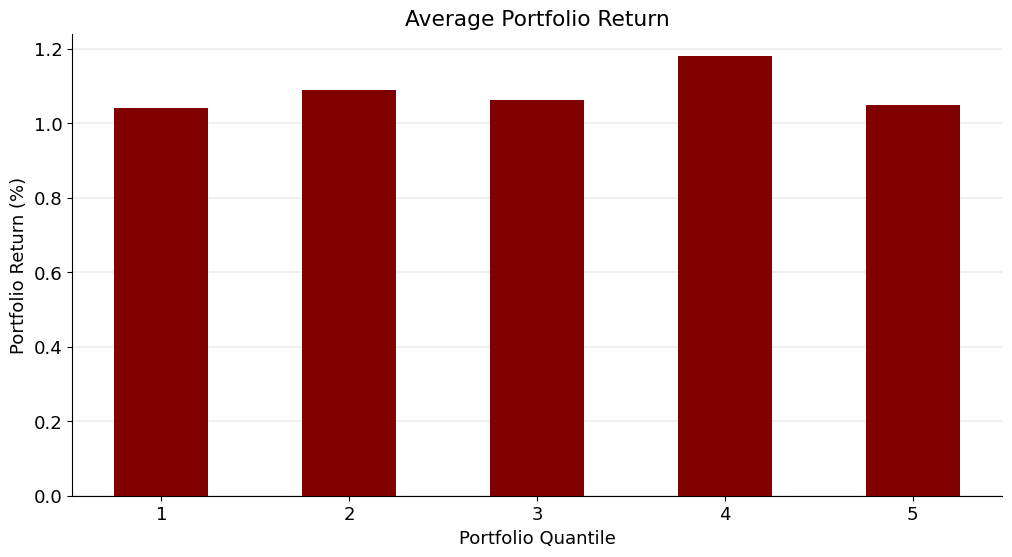

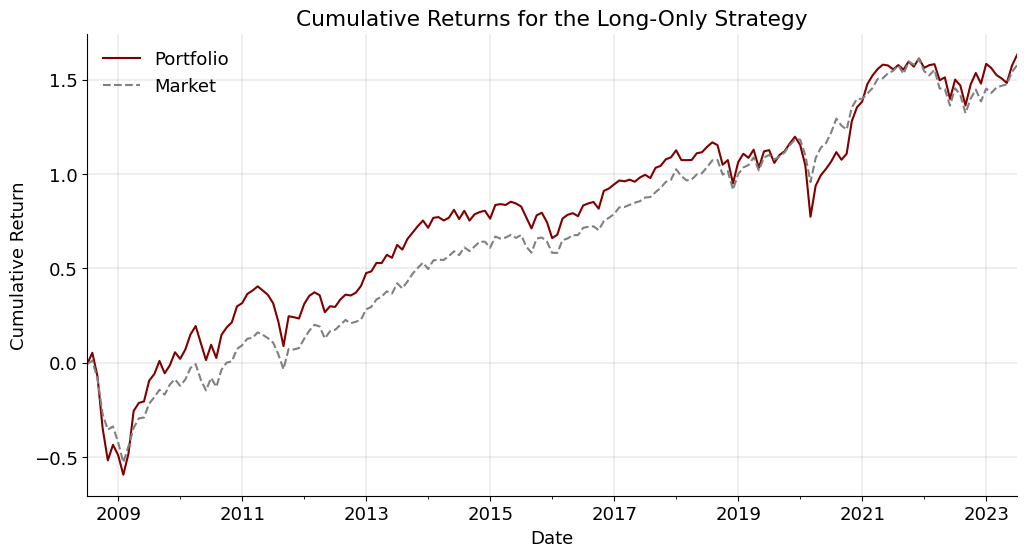

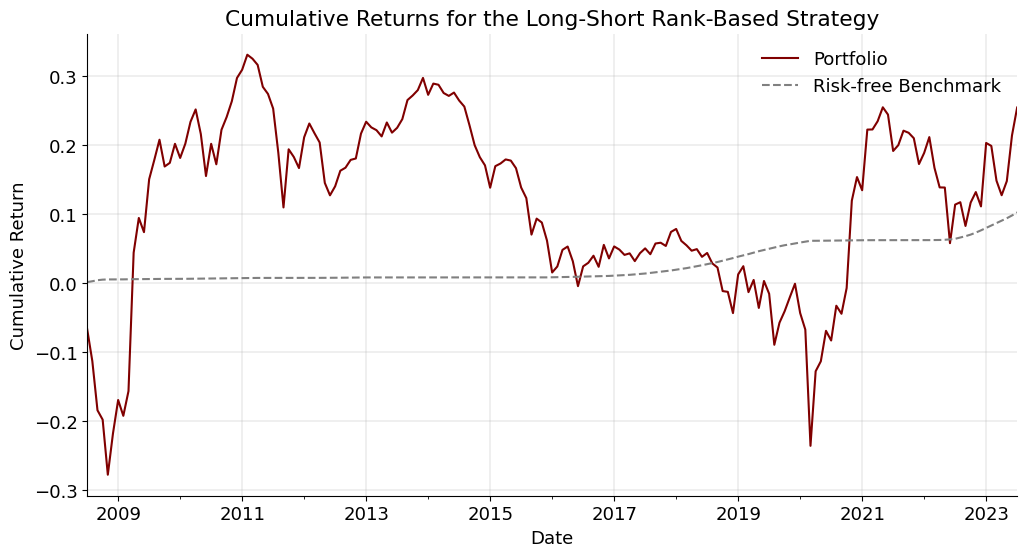

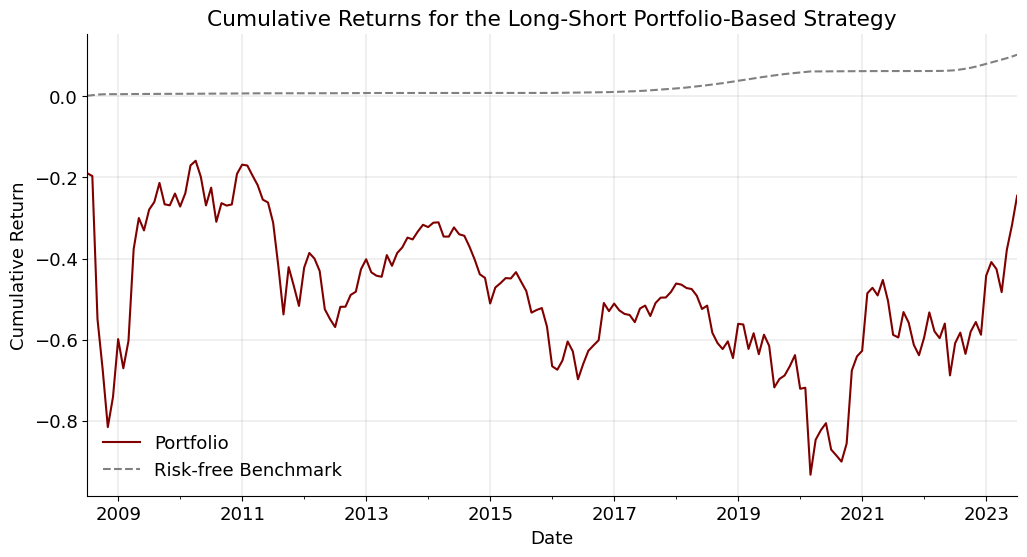

In [13]:
for permno in tqdm(df['permno'].unique()):
    excess_ret = df.loc[df['permno']==permno, ['excess_ret', 'ldate']].set_index('ldate').rename(columns={"excess_ret": permno})
    df.loc[df['permno']==permno, 'signal'] = get_signal(excess_ret, mkt, 36).values
    
df['signal'] = qpm.create_lag(df, var_name='signal', lag=1)
df_select = qpm.select_sample(df, sample_start = _SAMPLE_START, sample_end = _SAMPLE_END, remove_micro_caps = _REMOVE_MICRO_CAPS)

df_select, df_rets = qpm.create_portfolios(df_select, sort_frequency = 'Monthly', num_port = _NUM_PORT)

qpm.analyze_strategy(df_rets, analysis_type = 'Performance')